In [1]:
import torch
from scipy.linalg import hadamard
import matplotlib.pyplot as plt

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
d = torch.tensor(256).to(DEVICE)
ITERS = torch.tensor(1e3).type(torch.int32).to(DEVICE)
x = torch.randn(d).to(DEVICE)
DEVICE

device(type='cuda')

In [3]:
def lloyd_max(x, k, MAX_ITERS=1000):
    codebook = torch.linspace(torch.min(x), torch.max(x), k).to(DEVICE)
    for _ in range(MAX_ITERS):
        assigns = torch.argmin(abs(x.unsqueeze(1) - codebook), 1)
        new_codebook = torch.zeros_like(codebook)
        for i in range(k):
          values_under_i = x[assigns==i]
          if values_under_i.numel()!=0:
            new_codebook[i] = torch.mean(x[assigns==i])
          else:
            new_codebook[i] = codebook[i]
        if torch.allclose(new_codebook, codebook, atol=1e-5):
            break
        else:
            codebook=new_codebook
    return new_codebook

In [4]:
def deterministic_quantization(x, qlevels):
    left = torch.searchsorted(qlevels, x, side="right")-1
    right = left+1
    right[right==qlevels.numel()] = qlevels.numel()-1

    intervals = qlevels[torch.stack([left, right], axis=-1)]

    thresholds = (intervals[:, 0] + intervals[:, 1])/2
    return torch.where(
        x>thresholds,
        intervals[:, 1],
        intervals[:, 0]
    )

In [5]:
def eden(x, k, iters=ITERS):
    d = torch.tensor(x.size(0))
    eta = torch.sqrt(d)/torch.norm(x)

    x_hats = torch.zeros(ITERS, d)
    for i in range(ITERS):

        H = (hadamard(d)/torch.sqrt(d)).type(torch.float32)
        diag = torch.diag(torch.where(torch.rand(d)>0.5, 1, -1)).type(torch.float32)
        R = torch.mm(H, diag).to(DEVICE)

        Rx = torch.matmul(R, x)
        Rx *= eta

        qlevels = lloyd_max(eta*x, k)
        x_enc = deterministic_quantization(Rx, qlevels)

        scale = (torch.norm(x)**2) / torch.dot(Rx, x_enc)

        x_hats[i] = scale * torch.matmul(R.T, x_enc)
    return x_hats

In [6]:
levels = 2**torch.arange(1, 7).to(DEVICE)
nmse = torch.zeros_like(levels).type(torch.float32)

for i, k in enumerate(levels):
    print("k:", k.item())
    xhat = eden(x, k).to(DEVICE)
    # for proving unbiasedness:
    E_xhat = torch.mean(xhat, axis=0).to(DEVICE)
    print("The maximum distance between x and E[x_hat]:", torch.max(E_xhat - x).item())
    # avg NMSE
    avg_vNMSE = (torch.mean(torch.norm(x - xhat, dim=1)) / (torch.norm(x)**2)).item()
    print("Average NMSE:", avg_vNMSE, "\n")
    nmse[i] = avg_vNMSE

k: 2
The maximum distance between x and E[x_hat]: 0.3374786376953125
Average NMSE: 0.25006869435310364 

k: 4
The maximum distance between x and E[x_hat]: 0.24180936813354492
Average NMSE: 0.11929664015769958 

k: 8
The maximum distance between x and E[x_hat]: 0.17391729354858398
Average NMSE: 0.020556392148137093 

k: 16
The maximum distance between x and E[x_hat]: 0.19721770286560059
Average NMSE: 0.01755000464618206 

k: 32
The maximum distance between x and E[x_hat]: 0.1858816146850586
Average NMSE: 0.01674368791282177 

k: 64
The maximum distance between x and E[x_hat]: 0.1916959285736084
Average NMSE: 0.016057945787906647 



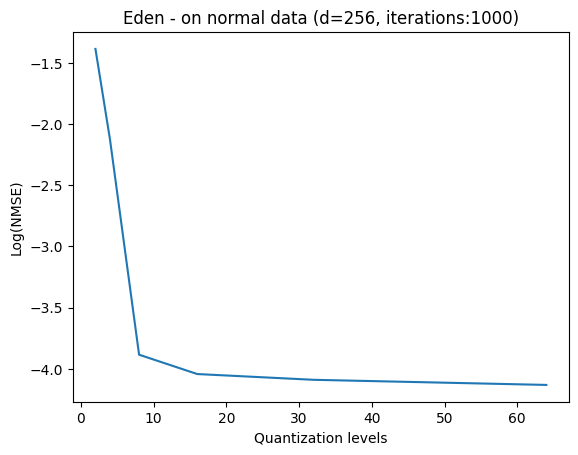

In [7]:
plt.plot(levels.cpu().numpy(), torch.log(nmse).cpu().numpy())
plt.xlabel("Quantization levels")
plt.ylabel("Log(NMSE)")
plt.title(f"Eden - on normal data (d={d}, iterations:{ITERS})")
plt.show()